## Linear regression

In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan

### Data preprocessing

In [85]:
df = pd.read_csv('podatki_PM.csv')

print('Null values: \n',df.isnull().sum())
df = df.drop(columns=['Datum'])

df.fillna(df.mean(), inplace=True)

print('Null values: \n',df.isnull().sum())
print('\n')
num_instances, num_features = df.shape
df['PM10'].astype(float) 
print(f"Number of instances: {num_instances}")
print(f"Number of features: {num_features}")


Null values: 
 Datum                         0
Glob_sevanje_mean             0
Hitrost_vetra_mean            0
Sunki_vetra_max               0
Padavine_sum                  0
Vlaga_mean                    0
Temperatura_Krvavec_mean      0
Temperatura_lokacija_mean     0
PM10                          0
PM_vceraj                    33
sinD                          0
cosD                          0
dtype: int64
Null values: 
 Glob_sevanje_mean            0
Hitrost_vetra_mean           0
Sunki_vetra_max              0
Padavine_sum                 0
Vlaga_mean                   0
Temperatura_Krvavec_mean     0
Temperatura_lokacija_mean    0
PM10                         0
PM_vceraj                    0
sinD                         0
cosD                         0
dtype: int64


Number of instances: 1213
Number of features: 11


### Data splitting and Target variable selection

In [86]:
y = df['PM10']  # Target variable
X = df.drop(columns=['PM10'])  # Features               
print(f"Range of y (PM10): [{y.min()}-{y.max()}]")

# 70/30 train-test split without random shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_s = scaler_X.fit_transform(X_train)
X_test_s = scaler_X.transform(X_test)

y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten() 
y_test_s = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")


Range of y (PM10): [1.8-114.9]
Training features shape: (849, 10)
Testing features shape: (364, 10)
Training target shape: (849,)
Testing target shape: (364,)


### Multiple Linear Regression

In [87]:
class MultipleLinearRegression:
    def __init__(self, polynomial_degree=1, log_transform=False):
        """
        Initialize the regression model.

        Parameters:
        polynomial_degree : int, optional
            The degree of the polynomial features to be generated (default is 1).
        log_transform : bool, optional
            Whether to apply logarithmic transformation to the target variable (default is False).
        """
        self.beta = None
        self.polynomial_degree = polynomial_degree
        self.log_transform = log_transform
        self.mean_target = None
        self.std_target = None

    def fit(self, X, y):
        """
        Fit the model using the normal equation.

        Parameters:
        X : numpy array or pandas DataFrame
            The input features (matrix).
        y : numpy array or pandas Series
            The target variable (vector).
        """
        if self.log_transform:
            y = np.log(y)

        if self.polynomial_degree > 1:
            X = self._generate_polynomial_features(X)

        X = np.c_[np.ones(X.shape[0]), X]
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ y 

    def _generate_polynomial_features(self, X):
        """
        Generate polynomial features of the specified degree.

        Parameters:
        X : numpy array or pandas DataFrame
            The input features.

        Returns:
        numpy array
            The input features with added polynomial features.
        """
        X_poly = X.copy()
        for degree in range(2, self.polynomial_degree + 1):
            X_poly = np.c_[X_poly, X ** degree]
        return X_poly

    def predict(self, X):
        """
        Predict the target variable using the learned coefficients.

        Parameters:
        X : numpy array or pandas DataFrame
            The input features for prediction.

        Returns:
        numpy array
            The predicted values.
        """
        if self.polynomial_degree > 1:
            X = self._generate_polynomial_features(X)
        
        X = np.c_[np.ones(X.shape[0]), X]  
        predictions = X @ self.beta

        # Reversing logarithmic transformation if it was applied
        if self.log_transform:
            predictions = np.exp(predictions)

        return predictions

    def get_coefficients(self):
        """
        Get the learned coefficients of the model.

        Returns:
        numpy array
            The coefficients of the model.
        """
        return self.beta

In [88]:
model = MultipleLinearRegression()
model.fit(X_train, y_train)
y_pred_custom = model.predict(X_train)
print("Calculated coefficients (beta):", model.get_coefficients())

Calculated coefficients (beta): [ 4.64121501e+01  3.25713628e-02 -2.83160750e+00 -9.68148514e-01
 -2.27105425e-01 -2.37595054e-01  4.71115184e-01 -1.18019711e+00
  5.47713643e-01 -2.57394213e+00  1.53883545e+00]


### Test: Compare the manually written linear regression model with the scikit-learn model

In [89]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"Mean Squared Error: {mse:.3f}")
    print(f"R-squared: {r2:.3f}\n")

#### Fit the linear regression model from scikit-learn

In [9]:
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_train)

#### Custom model and scikit-learn model evaluation

In [90]:
evaluate_model(y_train, y_pred_custom, "Custom Multiple Linear Regression")
evaluate_model(y_train, y_pred_sklearn, "Scikit-Learn Linear Regression")

Custom Multiple Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667

Scikit-Learn Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667



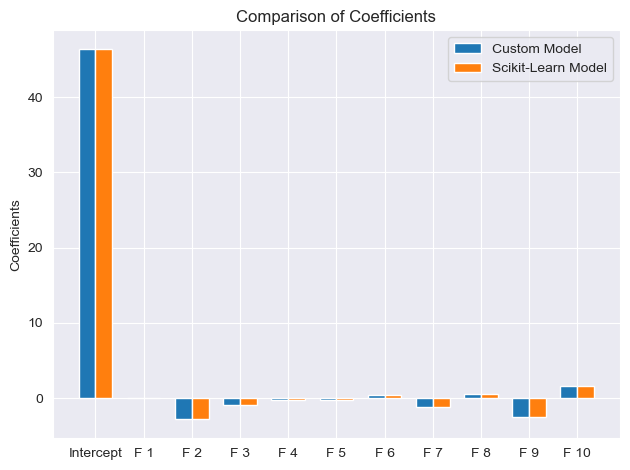

In [92]:
# Plotting the coefficients
coefficients_custom = model.get_coefficients()
coefficients_sklearn = np.insert(sklearn_model.coef_, 0, sklearn_model.intercept_)

labels = [f'F {i+1}' for i in range(X.shape[1])]
labels = ['Intercept'] + labels

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, coefficients_custom, width, label='Custom Model')
rects2 = ax.bar(x + width/2, coefficients_sklearn, width, label='Scikit-Learn Model')

ax.set_ylabel('Coefficients')
ax.set_title('Comparison of Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

### Diagnose your linear regression with diagnostic plots

#### Residuals vs. Fitted Values Plot
Check for non-linearity
If there is a clear pattern (such as curves or a U-shape), it indicates non-linearity.

Custom Multiple Linear Regression Performance


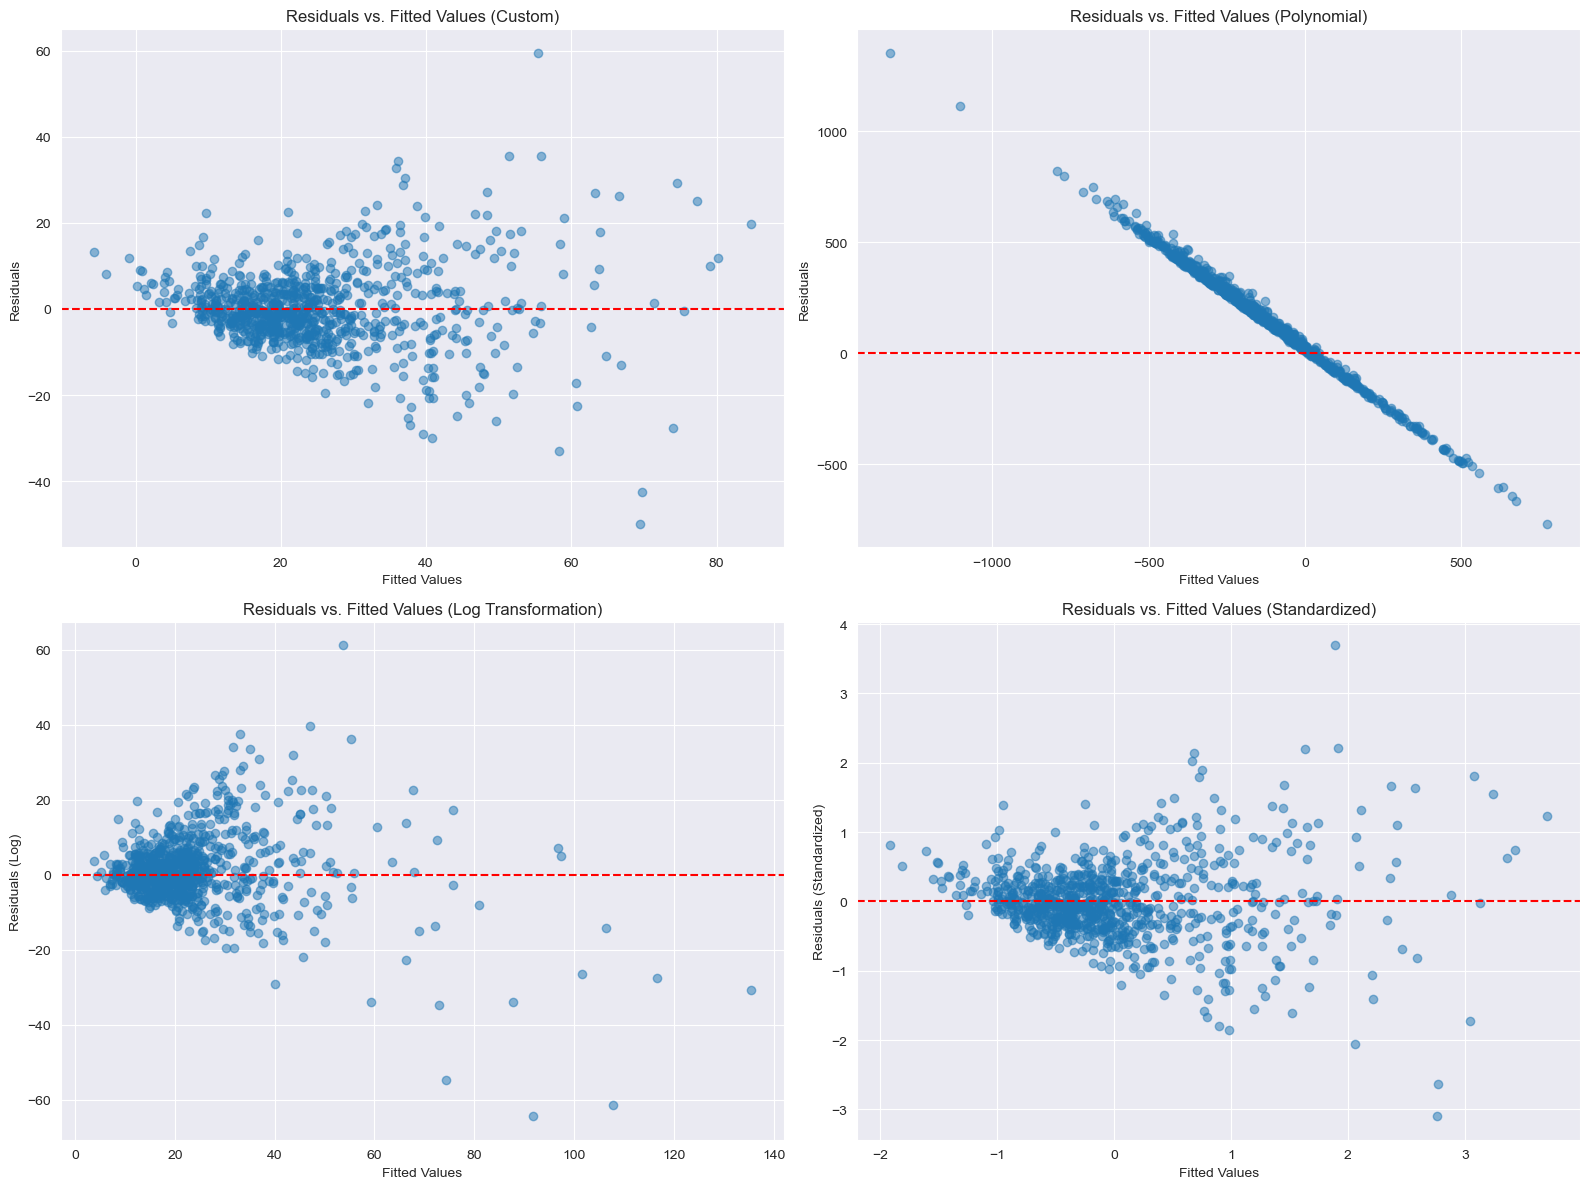

In [93]:
import matplotlib.pyplot as plt

print('Custom Multiple Linear Regression Performance')
residuals = y_train - y_pred_custom

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot for Custom Multiple Linear Regression
axs[0, 0].scatter(y_pred_custom, residuals, alpha=0.5)
axs[0, 0].axhline(y=0, color='r', linestyle='--')
axs[0, 0].set_title('Residuals vs. Fitted Values (Custom)')
axs[0, 0].set_xlabel('Fitted Values')
axs[0, 0].set_ylabel('Residuals')

# Plot for Polynomial Regression
model_polynomial = MultipleLinearRegression(polynomial_degree=5)
model_polynomial.fit(X_train, y_train) 
y_pred_polynomial = model_polynomial.predict(X_train)
residuals2 = y_train - y_pred_polynomial

axs[0, 1].scatter(y_pred_polynomial, residuals2, alpha=0.5)
axs[0, 1].axhline(y=0, color='r', linestyle='--')
axs[0, 1].set_title('Residuals vs. Fitted Values (Polynomial)')
axs[0, 1].set_xlabel('Fitted Values')
axs[0, 1].set_ylabel('Residuals')

# Plot for Logarithmic Transformation of the Target Variable
model_log = MultipleLinearRegression(log_transform=True)
model_log.fit(X_train, y_train)  
y_pred_log = model_log.predict(X_train) 
residuals_log = y_train - y_pred_log 

axs[1, 0].scatter(y_pred_log, residuals_log, alpha=0.5)
axs[1, 0].axhline(y=0, color='r', linestyle='--')
axs[1, 0].set_title('Residuals vs. Fitted Values (Log Transformation)')
axs[1, 0].set_xlabel('Fitted Values')
axs[1, 0].set_ylabel('Residuals (Log)')

# Plot for Standardized Target Variable
model_standardized = MultipleLinearRegression()
model_standardized.fit(X_train_s, y_train_s)
y_pred_standardized = model_standardized.predict(X_train_s)
residuals_standardized = y_train_s - y_pred_standardized

axs[1, 1].scatter(y_pred_standardized, residuals_standardized, alpha=0.5)
axs[1, 1].axhline(y=0, color='r', linestyle='--')
axs[1, 1].set_title('Residuals vs. Fitted Values (Standardized)')
axs[1, 1].set_xlabel('Fitted Values')
axs[1, 1].set_ylabel('Residuals (Standardized)')

plt.tight_layout()
plt.show()


#### Normal Q-Q (Quantile-Quantile) Plot

With this plot we can see whether the dataset follows normal distribution. 

NOTE: A Q-Q plot compares the quantiles of a dataset against the quantiles of a theoretical distribution, which in this case is the normal distribution. If the dataset is normally distributed, the points will fall approximately along a straight line.

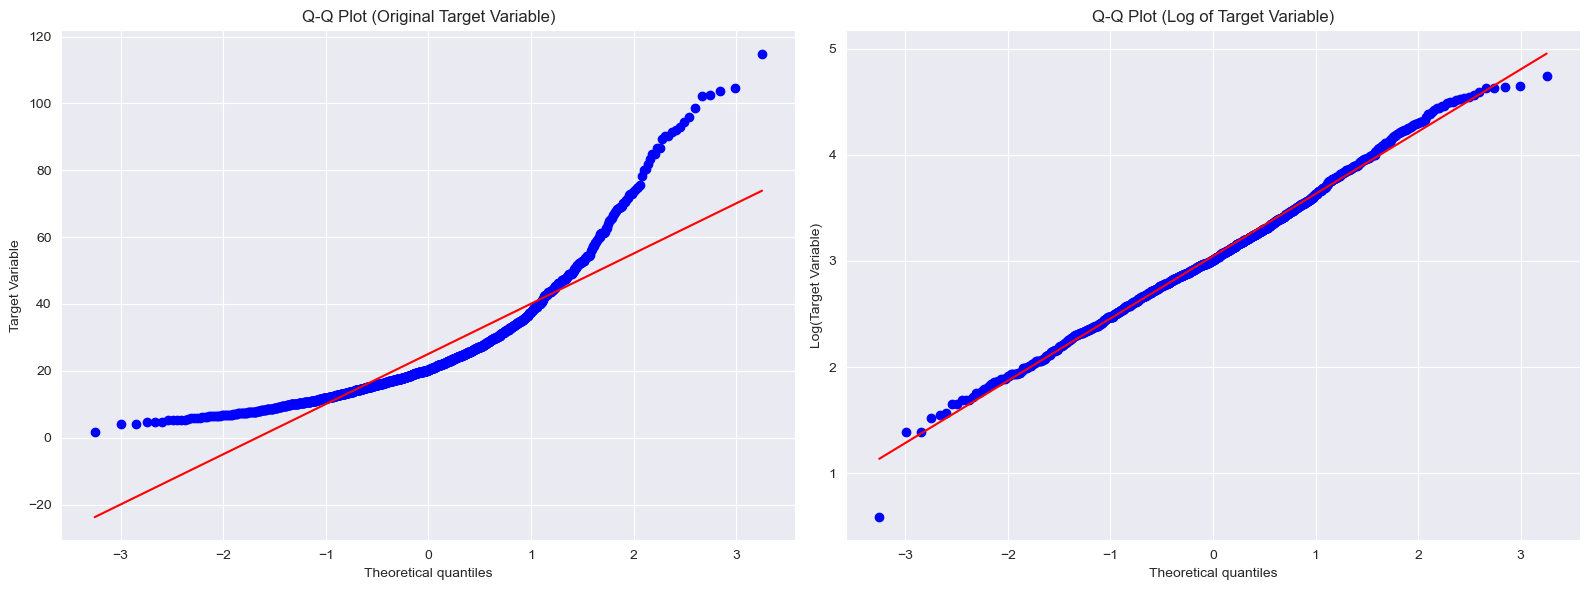

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

stats.probplot(y, dist="norm", plot=axs[0])
axs[0].set_title('Q-Q Plot (Original Target Variable)')
axs[0].set_ylabel('Target Variable')

log_y = np.log(y) 
stats.probplot(log_y, dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot (Log of Target Variable)')
axs[1].set_ylabel('Log(Target Variable)')

plt.tight_layout()
plt.show()

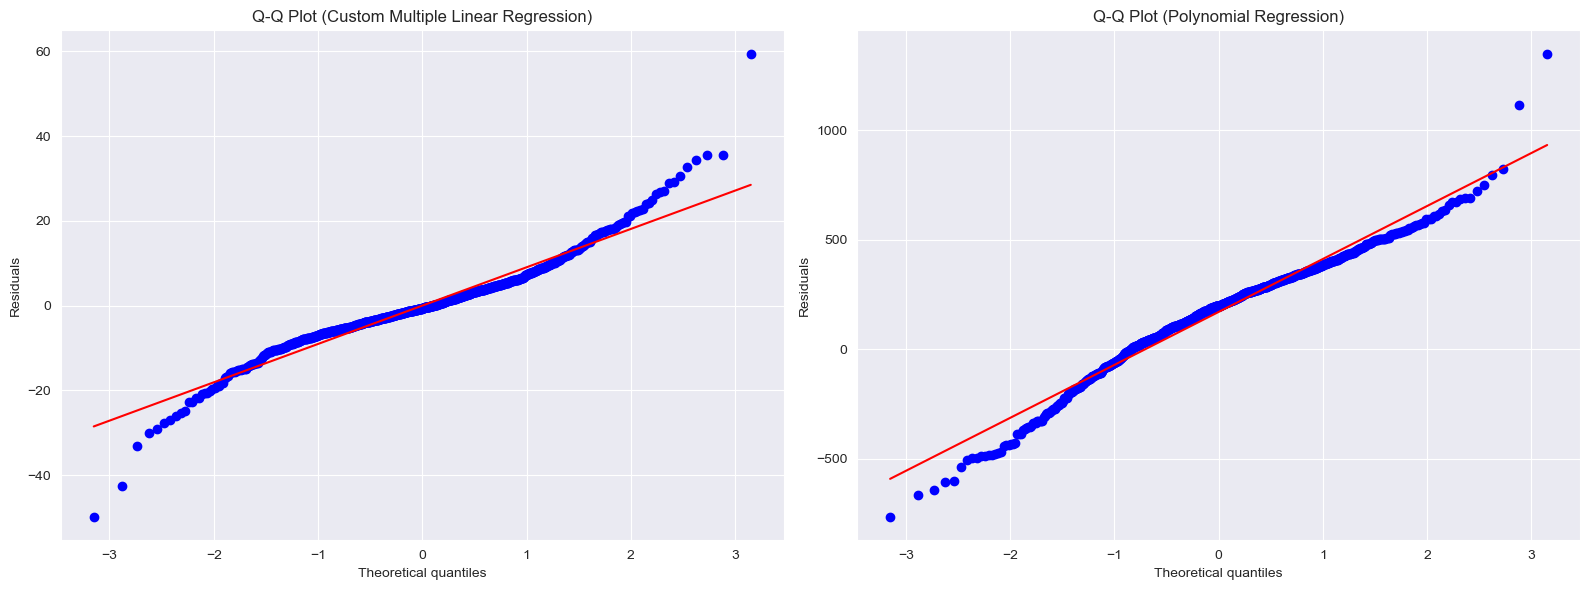

In [76]:
# Checking if the residuals are normally distributed
# NOTE: If the residuals are normally distributed, it indicates that the model is likely a good fit for the data.

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

stats.probplot(residuals, dist="norm", plot=axs[0])
axs[0].set_title('Q-Q Plot (Custom Multiple Linear Regression)')
axs[0].set_ylabel('Residuals')

stats.probplot(residuals2, dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot (Polynomial Regression)')
axs[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

    

####  Breusch-Pagan Test for Heteroscedasticity

A p-value less than 0.05 suggests heteroscedasticity

In [79]:
bp_test = het_breuschpagan(residuals, np.c_[np.ones(X_train.shape[0]), X_train])
# bp_test returns: (Lagrange Multiplier statistic, p-value, f-value, f p-value)
print(bp_test)
print(f'Breusch-Pagan test p-value: {bp_test[1]}')
if bp_test[1] < 0.05:
    print("The test indicates heteroscedasticity (p < 0.05).")
else:
    print("The test does not indicate heteroscedasticity (p >= 0.05).")

(183.95903511609995, 3.527334675416712e-34, 23.180176796207423, 1.0926041962590453e-38)
Breusch-Pagan test p-value: 3.527334675416712e-34
The test indicates heteroscedasticity (p < 0.05).
